# Import Data

Import the the alerts and transactions data sets from the following paper:

> Jensen, Rasmus; Ferwerda, Joras; Jørgensen, Kristian; Jensen, Erik; Borg, Martin; Krogh, Morten; et al. (2023). SynthAML: a Synthetic Data Set to Benchmark Anti-Money Laundering Methods. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.6504421.v1

In [1]:
import duckdb
import pandas as pd
import plotnine as p9
import numpy as np

# Read CSV files using DuckDB and convert to pandas data frames
con = duckdb.connect()

df_alerts = con.execute("SELECT * FROM 'synthetic_alerts.csv'").df()
df_transactions = con.execute("SELECT * FROM 'synthetic_transactions.csv'").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [2]:
df_alerts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   AlertID  20000 non-null  int64         
 1   Date     20000 non-null  datetime64[us]
 2   Outcome  20000 non-null  object        
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 468.9+ KB


In [3]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232955 entries, 0 to 16232954
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   AlertID    int64         
 1   Timestamp  datetime64[us]
 2   Entry      object        
 3   Type       object        
 4   Size       float64       
dtypes: datetime64[us](1), float64(1), int64(1), object(2)
memory usage: 619.2+ MB


## Reproduce Figures 3 and 4

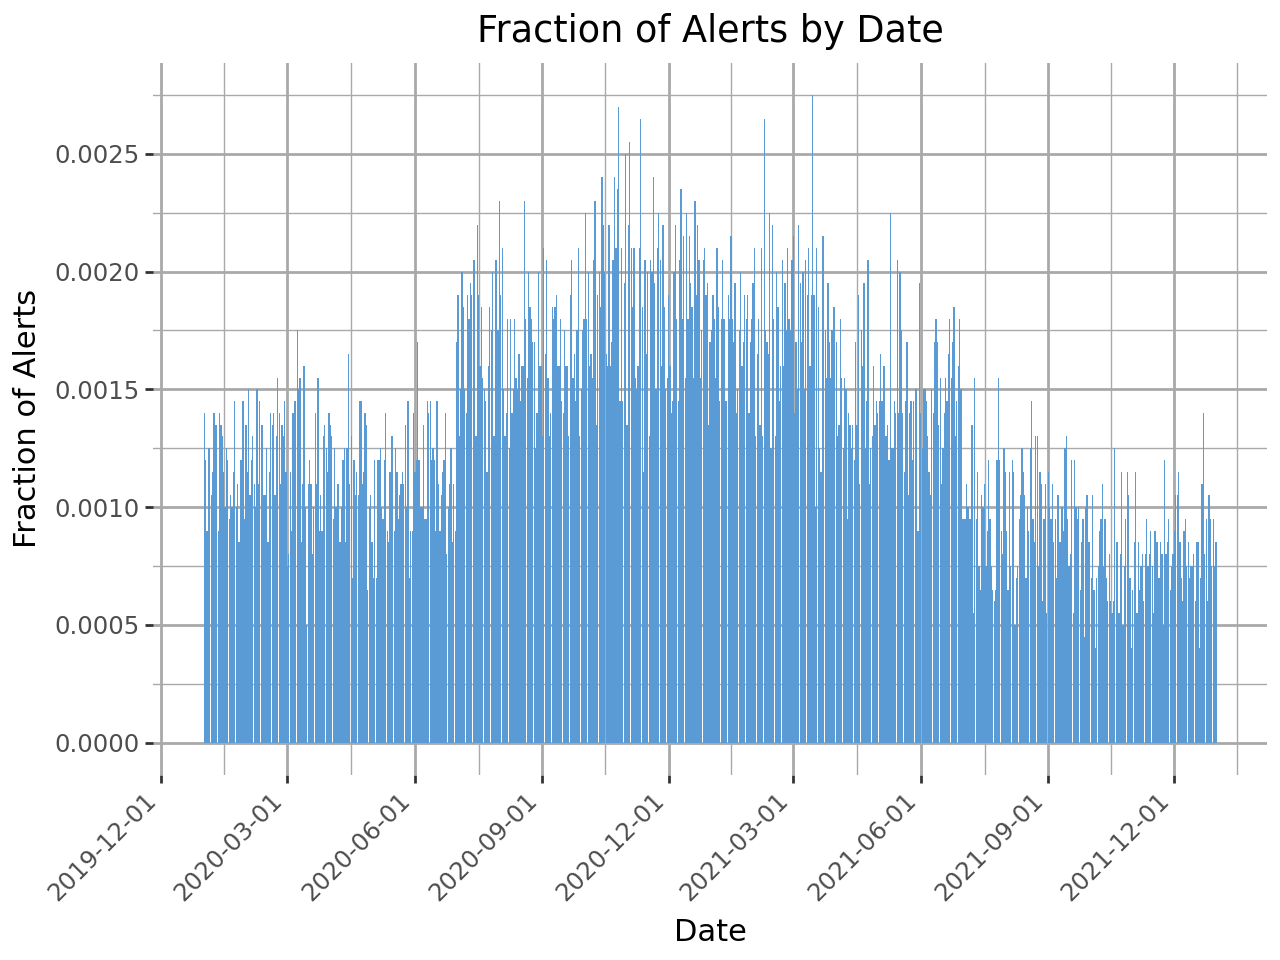

In [4]:
# Aggregate data by date
df_alerts_agg = (
    df_alerts
        .copy(deep=True)
        .Date
        .value_counts()
        .reset_index(name='AlertCount')
    )

df_alerts_agg['Fraction_of_Alerts'] = df_alerts_agg['AlertCount'] / df_alerts_agg['AlertCount'].sum()

# Plot
(
p9.ggplot(df_alerts_agg, p9.aes(x='Date', y='Fraction_of_Alerts')) +
    p9.geom_bar(stat='identity', fill='#5B9BD5') +  # Excel blue color
    p9.labs(title='Fraction of Alerts by Date', x='Date', y='Fraction of Alerts') +
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1),
            plot_background=p9.element_rect(fill='white'),
            panel_background=p9.element_rect(fill='white'),
            panel_grid_major=p9.element_line(color='darkgray'),
            panel_grid_minor=p9.element_line(color='darkgray')) +
    p9.scale_x_datetime(date_breaks='3 months') +
    p9.scale_y_continuous(breaks=np.arange(0, 0.003, 0.0005))  # Show gridlines every 0.001

)


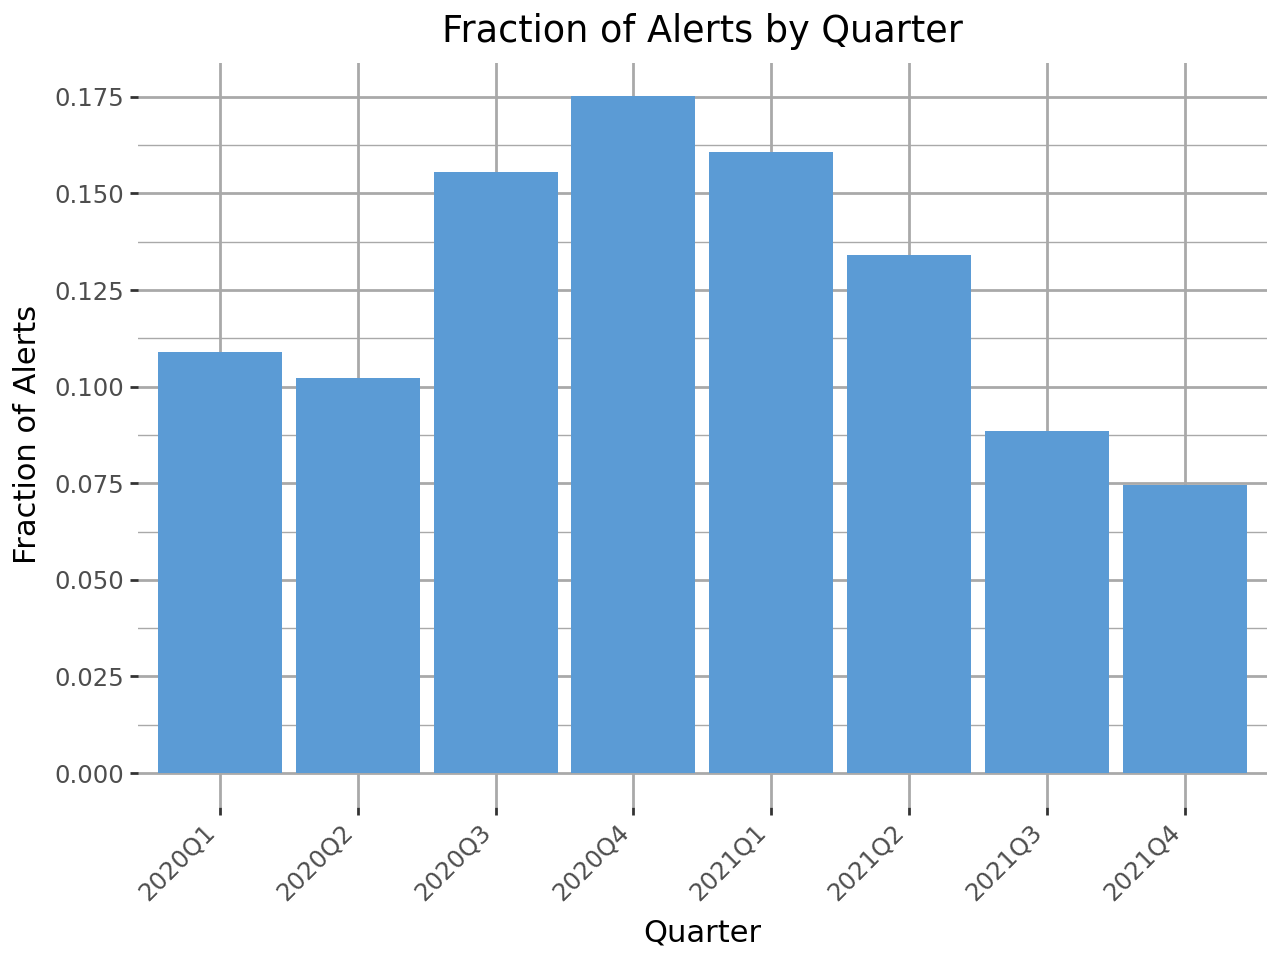

In [5]:
# Convert dates to quarters and aggregate
df_alerts_quarterly = (
    df_alerts_agg
        .copy(deep=True)
        .assign(Quarter=lambda x: x['Date'].dt.to_period('Q'))
        .groupby('Quarter')
        .agg({'AlertCount': 'sum'})
        .reset_index()
)

df_alerts_quarterly['Fraction_of_Alerts'] = df_alerts_quarterly['AlertCount'] / df_alerts_quarterly['AlertCount'].sum()

# Plot
(
p9.ggplot(df_alerts_quarterly, p9.aes(x='Quarter', y='Fraction_of_Alerts')) +
    p9.geom_bar(stat='identity', fill='#5B9BD5') +
    p9.labs(title='Fraction of Alerts by Quarter', x='Quarter', y='Fraction of Alerts') +
    p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1),
            plot_background=p9.element_rect(fill='white'),
            panel_background=p9.element_rect(fill='white'),
            panel_grid_major=p9.element_line(color='darkgray'),
            panel_grid_minor=p9.element_line(color='darkgray')) +
    p9.scale_y_continuous(breaks=np.arange(0, 0.2, 0.025))
)

## Figure 5

The transactions data set exceeds 16 MM rows. In order to generate the figure, a random sample of 500,000 rows is taken.

In [6]:
df_transactions_sample = df_transactions.copy(deep=True).sample(500000, random_state=42)

# Set categories in alphabetical order
df_transactions_sample['Entry'] = (df_transactions_sample['Entry']
                                .astype('category')
                                .cat.reorder_categories(['Debit', 'Credit'], ordered=True))

unique_types = df_transactions_sample['Type'].unique()

sorted_types = sorted(unique_types,reverse=True)

df_transactions_sample['Type'] = (df_transactions_sample['Type']
                                .astype("category")
                                .cat.reorder_categories(sorted_types, ordered=True))

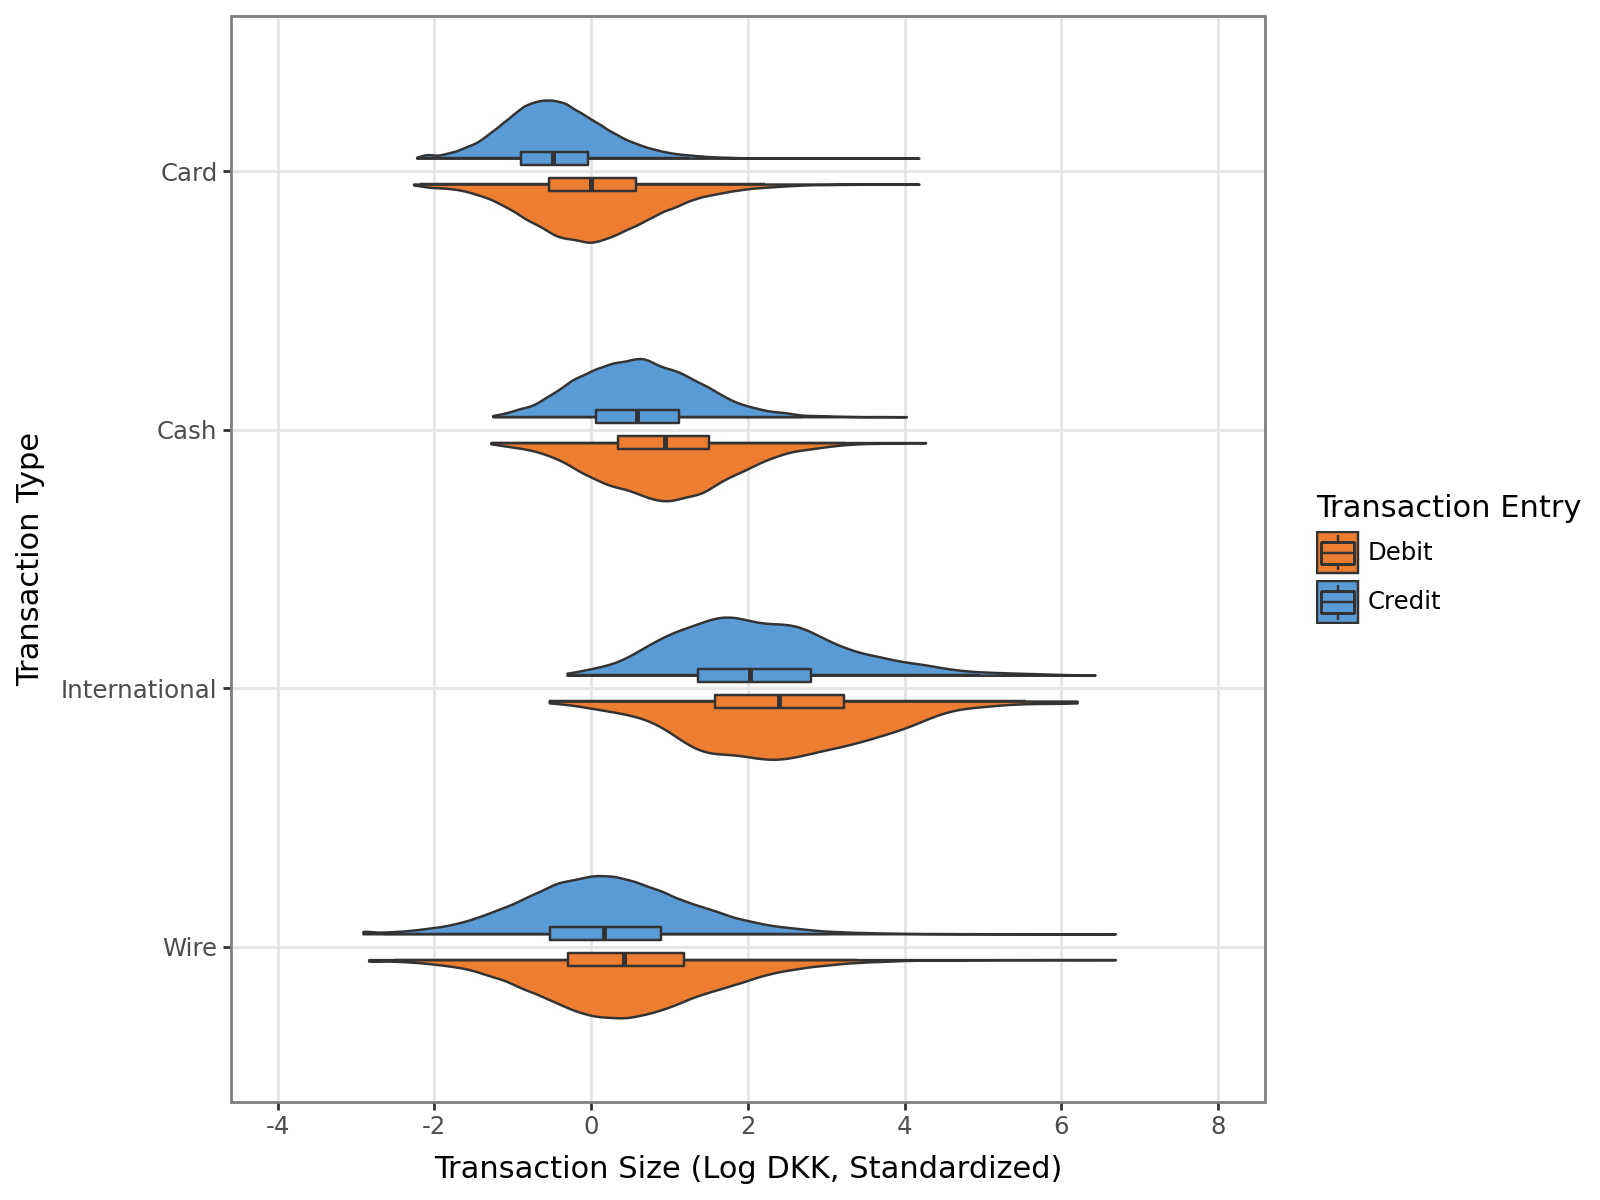

In [7]:

# Excel colors
excel_colors = ['#ED7D31','#5B9BD5']  # Blue and Orange from Excel

(p9.ggplot(df_transactions_sample, p9.aes(x='Type', y='Size', fill='Entry'))
    + p9.geom_violin(position=p9.position_dodge(width=0.2), scale="width", style="left-right")
    + p9.geom_boxplot(width=0.1, position=p9.position_dodge(width=0.2), outlier_alpha=0, outlier_shape='')
    + p9.labs(
        x="Transaction Type",
        y="Transaction Size (Log DKK, Standardized)",
        fill="Transaction Entry"
    )
    + p9.theme_bw()
    + p9.theme(
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_rect(fill='white'),
        plot_background=p9.element_rect(fill='white'),
    )
    + p9.scale_y_continuous(breaks=range(-4, 10, 2), limits=[-4, 8])
    + p9.scale_fill_manual(values=excel_colors)
    + p9.theme(figure_size=(8, 6))
    + p9.coord_flip()
)


## Figure 7

Due to the size of the transactions data set, use the duckdb library, then convert the output to a pandas data frame.

In [8]:
df_transactions_agg = duckdb.query("""
    SELECT Type, Entry, COUNT(*) AS Count
    from df_transactions
    GROUP BY Type, Entry
    ORDER BY Type, Entry
    """).to_df()

df_transactions_agg['FractionOfTransactions'] = df_transactions_agg['Count'] / df_transactions_agg['Count'].sum()

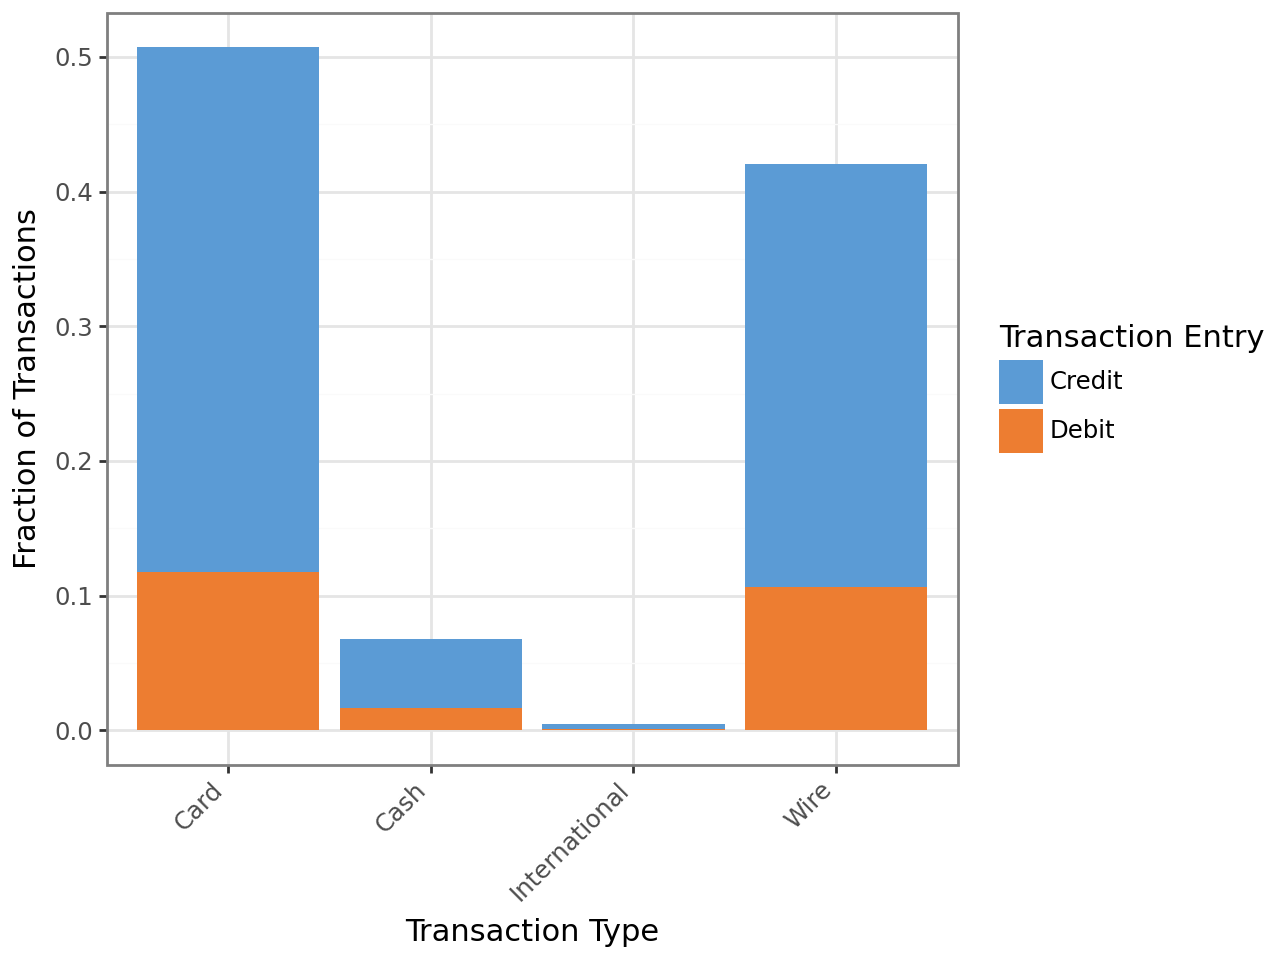

In [9]:
excel_colors_reversed = ['#5B9BD5', '#ED7D31']

(p9.ggplot(df_transactions_agg, p9.aes(x='Type', y='FractionOfTransactions', fill='Entry'))
    + p9.geom_bar(stat='identity') 
    + p9.labs(
        x='Transaction Type',
        y='Fraction of Transactions',
        fill='Transaction Entry'
    )
    + p9.theme_bw()
    + p9.theme(
        panel_background=p9.element_rect(fill='white'),
        plot_background=p9.element_rect(fill='white'),
        axis_text_x=p9.element_text(rotation=45, hjust=1)
    )
    + p9.scale_fill_manual(values=excel_colors_reversed)
)

Next step is feature engineering.